In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [34]:
# 读取数据
data = pd.read_csv(r'D:\ArcgisData\pred_organic_p_n\feature_table\feature_table_result\all_result.csv')
print(len(data))
# 删除有缺失值的行
data.dropna(inplace=True)
len(data),data.columns

6808


(6806,
 Index(['Unnamed: 0', 'GDPOINTNPSOM', 'Ph', 'N', 'P', 'SOM', 'TWI5', 'TPI201',
        'TPI101', 'TPI11', 'TPI3', 'TMP', 'SOILQS', 'SLOP', 'PRE', 'NIGTH',
        'NDVI', 'DEM', 'CUR', 'ASP', 'PLCUR', 'POCUR', 'OSJL', 'LAT', 'LON',
        'DZ', 'DL'],
       dtype='object'))

In [35]:
data.drop(['Unnamed: 0','GDPOINTNPSOM','P','SOM'], axis=1, inplace=True)
data.columns

Index(['Ph', 'N', 'TWI5', 'TPI201', 'TPI101', 'TPI11', 'TPI3', 'TMP', 'SOILQS',
       'SLOP', 'PRE', 'NIGTH', 'NDVI', 'DEM', 'CUR', 'ASP', 'PLCUR', 'POCUR',
       'OSJL', 'LAT', 'LON', 'DZ', 'DL'],
      dtype='object')

In [36]:
data['DL'] = data['DL'].astype(str)
data['DZ'] = data['DZ'].astype(str)
data.dtypes

Ph        float64
N         float64
TWI5      float64
TPI201    float64
TPI101    float64
TPI11     float64
TPI3      float64
TMP       float64
SOILQS      int64
SLOP      float64
PRE       float64
NIGTH     float64
NDVI      float64
DEM       float64
CUR       float64
ASP       float64
PLCUR     float64
POCUR     float64
OSJL      float64
LAT       float64
LON       float64
DZ         object
DL         object
dtype: object

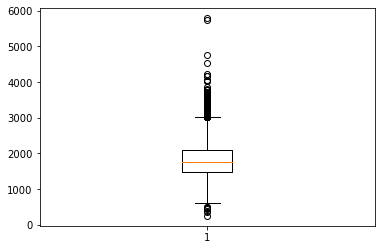

(6806, 23)


In [9]:
plt.boxplot(data["N"])
plt.show()
print(data.shape)

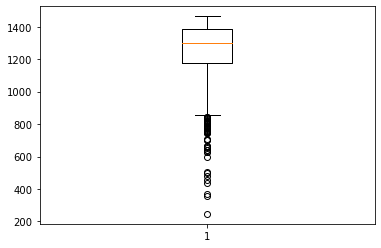

(1633, 23)


In [10]:
# 剔除离群值(3倍std)
outlier_threshold = data["N"].std()*3
s3_filter_data = data[abs(data['N']) < outlier_threshold]
s3_filter_data
plt.boxplot(s3_filter_data["N"])
plt.show()
print(s3_filter_data.shape)

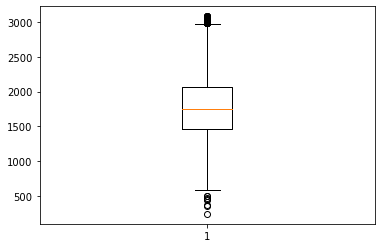

(6692, 23)


In [37]:
# 剔除离群值（Z-score）
z_scores = (data["N"]-data["N"].mean())/data["N"].std()
z_scores.describe()
# 设置阈值
z_score_filter= 2.6
z_filter_data = data[z_scores<z_score_filter]
z_filter_data
plt.boxplot(z_filter_data["N"])
plt.show()
print(z_filter_data.shape)

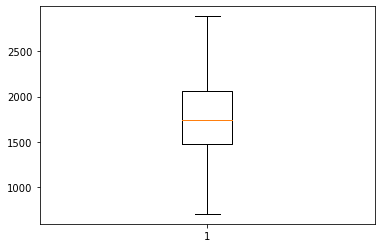

(6581, 23)


In [17]:
# 剔除离群值(IQR)
q1 = data['N'].quantile(0.25)
q3 = data['N'].quantile(0.75)
iqr = q3-q1
iqr_threshold = 1.3*iqr # 阈值1
iqr_filtered_data = data[(data['N'] >= q1 - iqr_threshold) & (data['N'] <= q3 + iqr_threshold)]
iqr_filtered_data
plt.boxplot(iqr_filtered_data["N"])
plt.show()
print(iqr_filtered_data.shape)

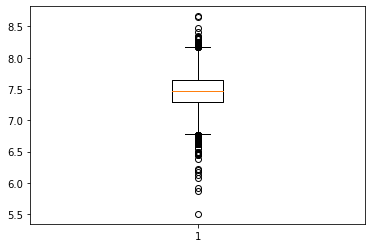

(6805, 21)


In [72]:
# log
log_data= data["N"].apply(np.log)
log_data
plt.boxplot(log_data)
plt.show()
print(data.shape)

In [38]:
data['N'].describe()

count    6806.000000
mean     1815.817514
std       488.486713
min       246.000000
25%      1475.250000
50%      1760.000000
75%      2091.000000
max      5784.000000
Name: N, dtype: float64

In [39]:
# 将label取为对数做训练
# data['organic'] = data['organic'].apply(np.log)
# 取z_score化后的数据做训练
data = z_filter_data
data.shape

(6692, 23)

In [40]:
data['N'].describe()

count    6692.000000
mean     1788.169456
std       440.241210
min       246.000000
25%      1471.000000
50%      1752.000000
75%      2072.000000
max      3081.000000
Name: N, dtype: float64

In [41]:
data.columns

Index(['Ph', 'N', 'TWI5', 'TPI201', 'TPI101', 'TPI11', 'TPI3', 'TMP', 'SOILQS',
       'SLOP', 'PRE', 'NIGTH', 'NDVI', 'DEM', 'CUR', 'ASP', 'PLCUR', 'POCUR',
       'OSJL', 'LAT', 'LON', 'DZ', 'DL'],
      dtype='object')

In [42]:
# 将目标值范围缩小
data.loc[:,'N']=data['N'].div(1000)

In [43]:
# 划分测试数据
train_data = data.sample(frac=0.8,random_state=0)   # 80%的数据用于训练
test_data = data.drop(train_data.index)                 # 20%的数据用于测试

In [44]:
label = 'N'
train_data[label].describe()

count    5354.000000
mean        1.786577
std         0.439359
min         0.370000
25%         1.473000
50%         1.748500
75%         2.069750
max         3.081000
Name: N, dtype: float64

In [45]:
# TabularPredictor.load("AutogluonModels\ag-20230802_083815\")  全要素
# TabularPredictor.load("AutogluonModels\ag-20230803_041226\")  全要素  presets="best_quality"
"""
num_stack_levels(默认值为1):用于集成多个模型时，可以指定要使用的级别数。较高的级别数可以提供更强大的模型集成能力，但可能会增加训练和推断时间。

num_bag_folds(默认值为8):用于bagging(随机森林)集成中的交叉验证折叠数。它决定了训练数据的划分和多个模型的训练次数。较大的值可以提供更准确的估计，但同时也会增加训练时间。

num_bag_sets(默认值为20):与num_bag_folds一起决定了bagging集成中的模型数量。num_bag_folds*num_bag_sets即为最终集成的模型数量。较大的值可以提供更强大的集成能力,但也会增加训练和推断时间。

这些参数用于调整集成学习过程中的细节，以获得更好的模型表现。可以根据具体的数据集和问题类型进行调整，并根据需求进行实验和调优。"""
# predictor = TabularPredictor(label=label).fit(train_data,time_limit=6000,presets="best_quality")
# 模型存放位置
model_path = r'D:\ArcgisData\pred_organic_p_n\pred_moudle\N_pred_moudle\zscore_normal_r2_div1000'
# model_path = r'D:\ArcgisData\pred_organic\organic_pred_moudle\对数化'
predictor = TabularPredictor(label=label,path=model_path,eval_metric='r2')
# predictor.fit(train_data,time_limit=10800,presets="best_quality",num_stack_levels = 5,num_bag_folds = 5,num_bag_sets = 30)
# predictor.fit(train_data,time_limit=10800,presets="best_quality")
predictor.fit(train_data,time_limit=10800)
# predictor = TabularPredictor.load(model_path)

Beginning AutoGluon training ... Time limit = 10800s
AutoGluon will save models to "D:\ArcgisData\pred_organic_p_n\pred_moudle\N_pred_moudle\zscore_normal_r2_div1000\"
AutoGluon Version:  0.8.2
Python Version:     3.9.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   622.12 GB / 808.56 GB (76.9%)
Train Data Rows:    5354
Train Data Columns: 22
Label Column: N
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (3.081, 0.37, 1.78658, 0.43936)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...


	Available Memory:                    57297.38 MB
	Train Data (Original)  Memory Usage: 1.48 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])  : 19 | ['Ph', 'TWI5', 'TPI201', 'TPI101', 'TPI11', ...]
		('int', [])    :  1 | ['SOILQS']
		('object', []) :  2 | ['DZ', 'DL']
	Types of features in processed data (raw dtype, special dtypes):
		('category', []) :  2 | ['DZ', 'DL']
		('float', [])    : 19 | ['Ph', 'T

In [46]:
# 获取最佳模型
best_model = predictor.get_model_best()
# 获取WeightedEnsemble_L3模型
# 获取模型的训练摘要
model_summary = predictor.fit_summary()
print(model_summary)

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.459868       0.059150  28.490743                0.000000           0.159555            2       True         12
1              CatBoost   0.444319       0.003000  16.704422                0.003000          16.704422            1       True          6
2         ExtraTreesMSE   0.438951       0.031559   0.385416                0.031559           0.385416            1       True          7
3            LightGBMXT   0.433459       0.002015   0.435943                0.002015           0.435943            1       True          3
4         LightGBMLarge   0.425087       0.004497   1.127783                0.004497           1.127783            1       True         11
5              LightGBM   0.420831       0.004001   0.570871                0.004001           0.570871 

In [47]:
# 测试数据集
y_test_pred = predictor.predict(test_data.drop(columns=[label]))
y_test = test_data[label]

In [48]:
# 训练数据集
y_train_pred = predictor.predict(train_data.drop(columns=[label]))
y_train = train_data[label]

In [49]:
# 计算残差
residuals_test =y_train - y_train_pred

In [50]:
# 高斯克里金
OK = OrdinaryKriging(train_data['LON'], train_data['LAT'], residuals_test, variogram_model='spherical')  # 高斯模型 linear:0.494,gaussian:0.492,exponential:0.497,spherical:0.50
kriging_predictions_test, _ = OK.execute('points', test_data['LON'], test_data['LAT'])
predictions_test = y_test_pred + kriging_predictions_test

# 计算R2
r2 = r2_score(y_test, predictions_test)
test_r2 = r2_score(y_test,y_test_pred)
train_r2 = r2_score(y_train,y_train_pred)
r2,test_r2,train_r2


(0.4643179884224836, 0.450435194796167, 0.7817568290057297)

In [28]:
# 重新计算预测值

def calc_predict_value(actual_value, predict_value):
    diff = np.abs(actual_value - predict_value)/actual_value
    modified_diff = np.where(diff <= 0.15, actual_value, predict_value)
    return modified_diff


In [52]:
t_pred = calc_predict_value(test_data[label],y_test_pred)
t_pred

array([24.1       , 28.82807922, 29.93417931, ..., 35.1507988 ,
       37.56521988, 34.9       ])

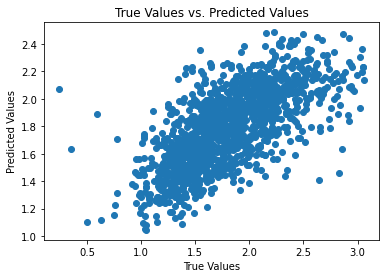

In [51]:
plt.scatter(y_test, predictions_test)

# 添加标签和标题
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs. Predicted Values')

# 显示图表
plt.show()

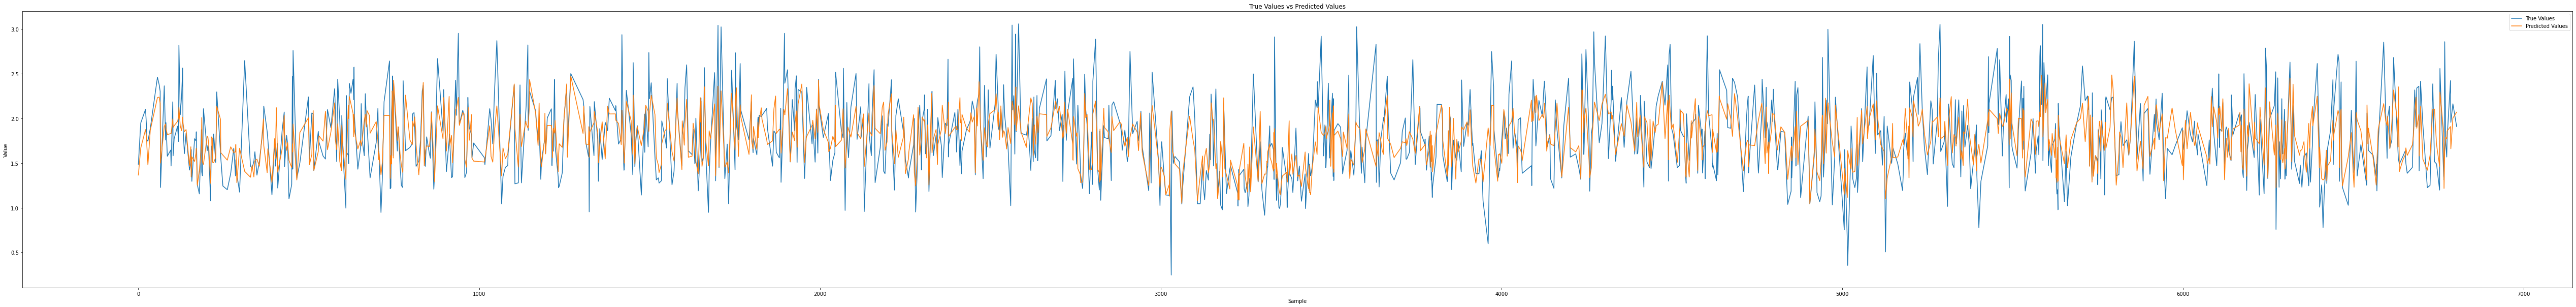

In [52]:
# 创建折线图
plt.figure(figsize=(90,10))
plt.plot(y_test, label='True Values')
plt.plot(predictions_test, label='Predicted Values')

# 图表标题和标签
plt.title('True Values vs Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Value')

# 添加图例
plt.legend()

# 显示图表
plt.show()

In [53]:
metrics = predictor.evaluate(test_data, silent=True)

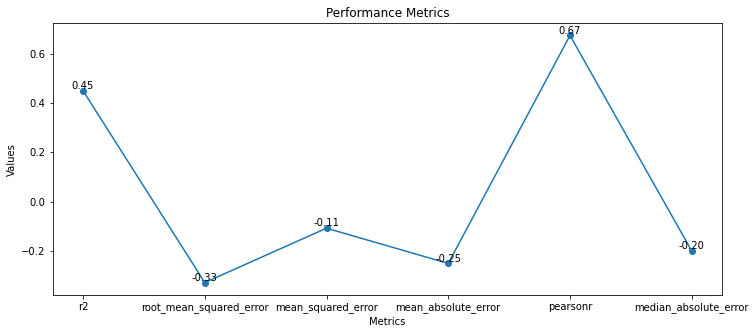

In [54]:
metric_names = list(metrics.keys())
metric_values = list(metrics.values())
plt.figure(figsize=(12,5))
plt.plot(metric_names, metric_values, marker='o')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Metrics')

# 标注数值
for i in range(len(metric_names)):
    plt.annotate(f'{metric_values[i]:.2f}', (metric_names[i], metric_values[i]), ha='center', va='bottom')

plt.show()


In [36]:

def calculate_modified_r2(y_true, y_pred):
    diff = np.abs(y_true - y_pred)/y_true
    modified_diff = np.where(diff <= 0.15, 0, np.abs(y_true - y_pred))
    modified_ssr = np.sum(modified_diff**2)
    
    mean = np.mean(y_true)
    total_diff = np.sum((y_true - mean)**2)
    
    r2 = 1 - (modified_ssr / total_diff)
    return r2

print(calculate_modified_r2(test_data[label], y_test_pred))

0.4457098611774116


In [55]:
model_value = predictor.leaderboard(train_data, silent=True)

In [56]:
fetures_value = predictor.feature_importance(train_data)
fetures_value

Computing feature importance via permutation shuffling for 22 features using 5000 rows with 5 shuffle sets...
	33.04s	= Expected runtime (6.61s per shuffle set)
	11.48s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
DL,0.191459,0.002229,2.205571e-09,5,0.196050,0.186869
Ph,0.149078,0.006094,3.342209e-07,5,0.161625,0.136532
SLOP,0.139783,0.002076,5.841028e-09,5,0.144058,0.135507
LAT,0.129100,0.004080,1.194927e-07,5,0.137500,0.120701
TPI201,0.111098,0.003986,1.984829e-07,5,0.119305,0.102891
LON,0.106162,0.001819,1.033224e-08,5,0.109907,0.102417
TMP,0.086350,0.002118,4.339222e-08,5,0.090711,0.081990
NDVI,0.064744,0.001046,8.184418e-09,5,0.066898,0.062589
DEM,0.061272,0.001091,1.206838e-08,5,0.063519,0.059025
TPI101,0.049217,0.000476,1.053394e-09,5,0.050198,0.048236


In [57]:
# 将索引添加为列
df = fetures_value
df.reset_index(level=0, inplace=True)
print(df)

     index  importance    stddev       p_value  n  p99_high   p99_low
0       DL    0.191459  0.002229  2.205571e-09  5  0.196050  0.186869
1       Ph    0.149078  0.006094  3.342209e-07  5  0.161625  0.136532
2     SLOP    0.139783  0.002076  5.841028e-09  5  0.144058  0.135507
3      LAT    0.129100  0.004080  1.194927e-07  5  0.137500  0.120701
4   TPI201    0.111098  0.003986  1.984829e-07  5  0.119305  0.102891
5      LON    0.106162  0.001819  1.033224e-08  5  0.109907  0.102417
6      TMP    0.086350  0.002118  4.339222e-08  5  0.090711  0.081990
7     NDVI    0.064744  0.001046  8.184418e-09  5  0.066898  0.062589
8      DEM    0.061272  0.001091  1.206838e-08  5  0.063519  0.059025
9   TPI101    0.049217  0.000476  1.053394e-09  5  0.050198  0.048236
10      DZ    0.044417  0.001035  3.540718e-08  5  0.046549  0.042285
11     ASP    0.044170  0.001393  1.185816e-07  5  0.047039  0.041302
12    OSJL    0.040439  0.001286  1.224646e-07  5  0.043086  0.037791
13    TWI5    0.0400

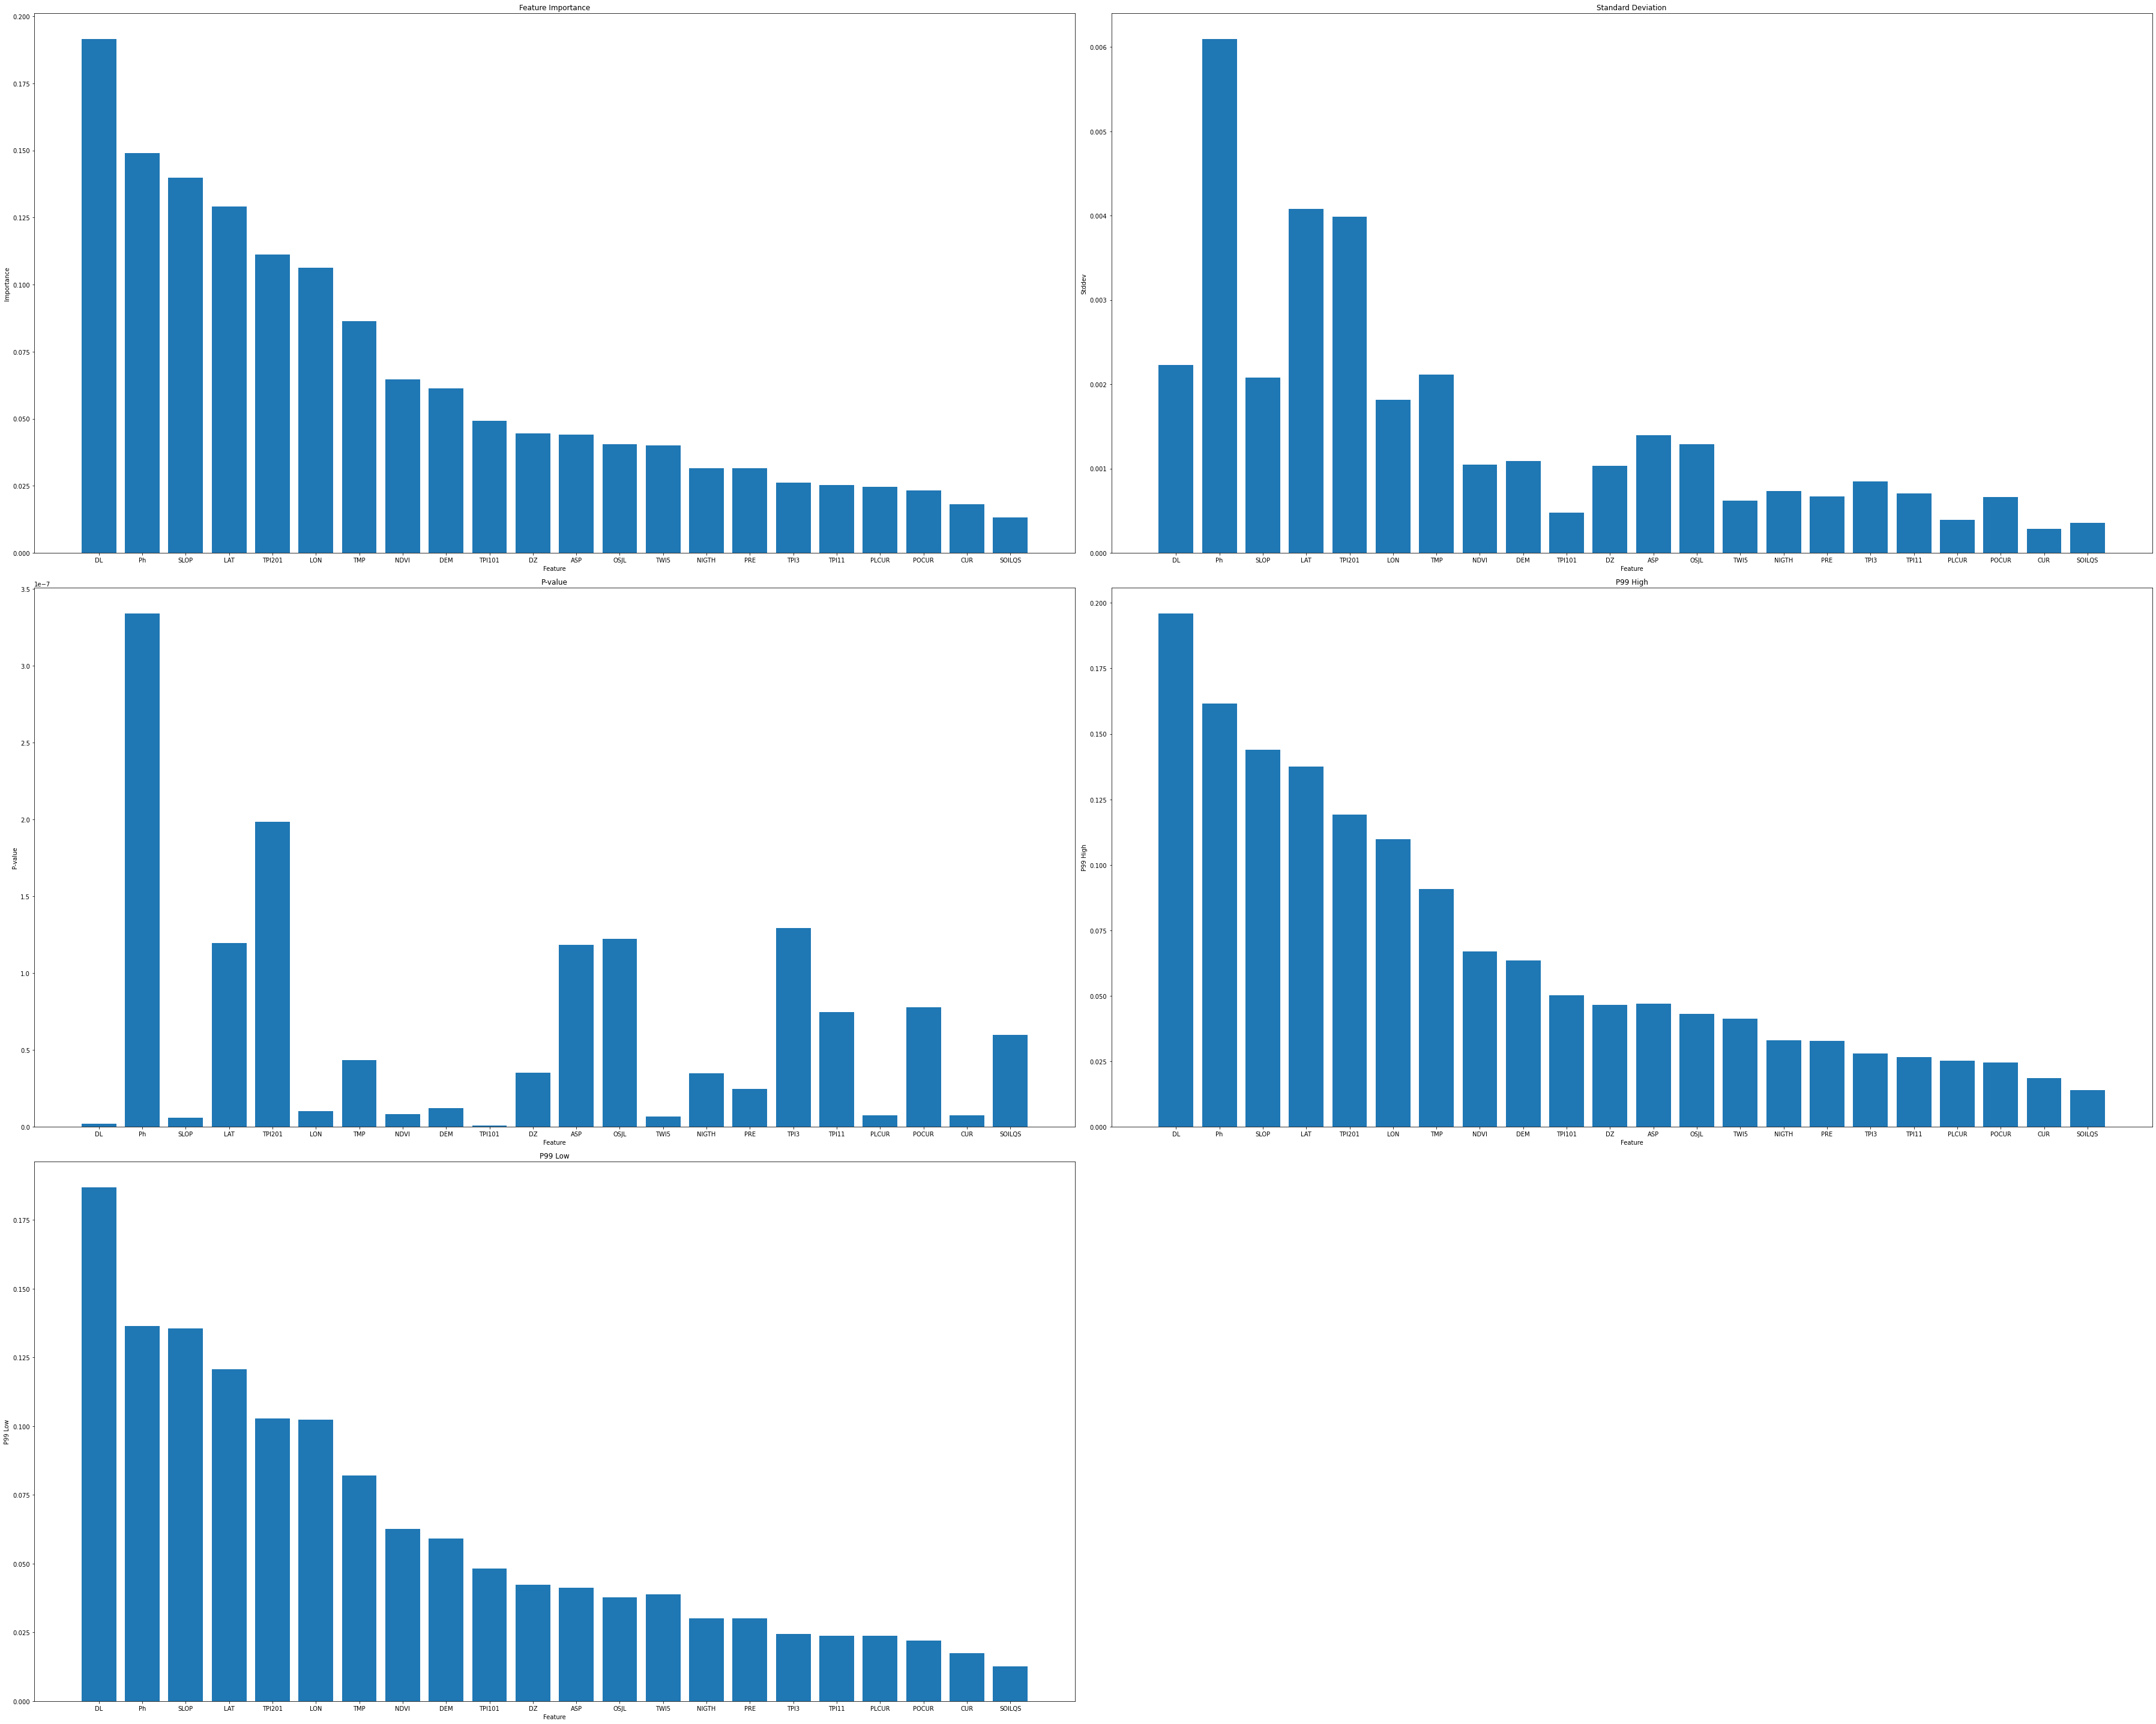

In [58]:
import matplotlib.pyplot as plt

# 设置图表大小
plt.figure(figsize=(50, 40))

# 绘制各个特征的重要性
plt.subplot(3, 2, 1)
plt.bar(df['index'], df['importance'])
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')

# 绘制各个特征的标准差
plt.subplot(3, 2, 2)
plt.bar(df['index'], df['stddev'])
plt.title('Standard Deviation')
plt.xlabel('Feature')
plt.ylabel('Stddev')

# 绘制各个特征的p值
plt.subplot(3, 2, 3)
plt.bar(df['index'], df['p_value'])
plt.title('P-value')
plt.xlabel('Feature')
plt.ylabel('P-value')

# 绘制各个特征的p99高值
plt.subplot(3, 2, 4)
plt.bar(df['index'], df['p99_high'])
plt.title('P99 High')
plt.xlabel('Feature')
plt.ylabel('P99 High')

# 绘制各个特征的p99低值
plt.subplot(3, 2, 5)
plt.bar(df['index'], df['p99_low'])
plt.title('P99 Low')
plt.xlabel('Feature')
plt.ylabel('P99 Low')

# 调整子图之间的间距
plt.tight_layout()

# 展示图表
plt.show()


In [ ]:
"""importance（重要性）：

取值范围：通常是一个非负实数，可以是介于0到无穷大之间的任意值。
意义：表示该特征对目标变量的预测能力的贡献程度。重要性值越高，说明该特征在预测模型中的影响力越大。
stddev（标准差）：

取值范围：通常是一个非负实数，可以是大于等于0的任意值。
意义：衡量特征值分散程度的统计指标。标准差值越大，表示样本数据在该特征上的波动越大。
p_value（P值）：

取值范围：通常是一个小于等于1的实数，可能是非负实数或者在特定情况下限制在0到1之间的实数。
意义：用于判断某个变量对目标变量是否具有显著影响。较小的p-value表示该特征与目标变量之间的关系更显著。
n（样本数量）：

取值范围：通常是一个正整数，表示用于计算这些特征参数的样本数量。
意义：表示用于计算特征参数的数据样本的数量。
p99_high（99%置信度上限）和p99_low（99%置信度下限）：

取值范围：通常是实数，可以是任意实数或在特定情况下限制在一定范围内的实数。
意义：表示特征的置信区间。在统计意义下，特征取值不会超过上限或低于下限的概率为99%。"""